In [1]:
import json

import pandas as pd
import spacy

from scipy.stats import hmean, norm

import time
import functools

import numpy as np

from collections import Counter, defaultdict
from itertools import chain
import re

import arrow 
import os

import googlemaps

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.figure_factory as ff
import plotly.graph_objs as go

import cufflinks as cf

import scattertext as st
from scattertext import word_similarity_explorer

from gender import GenderDetector

In [2]:
nlp = spacy.load('en')
nlp.Defaults.stop_words |= {'probably', 'perhaps', 'really', 'definitely', 'bit', 'sure', 
                            'is', 'was', 'were', 'will', 'be', 'has','had', 'have'}

In [3]:
init_notebook_mode(connected=True)

In [4]:
def timer(f):
    @functools.wraps(f)
    def wrapper(*args, **kwargs):
        t_start = time.perf_counter()
        res = f(*args, **kwargs)
        t_end = time.perf_counter()
        dt = t_end - t_start
        m, s = divmod(dt, 60)
        print(f'[{f.__name__}] elapsed time: {m:02.0f}:{s:02.0f}')
        return res
    return wrapper

class T:
    
    def __init__(self, review_file, users_file, attract_file):
        
        """
        collected TripAdvisor data comes as JSONs; this class does some data processing including imputation
        """

        self.DIR = os.path.join('data', 'melbourne')
        
        self.r = json.load(open(os.path.join(self.DIR, review_file)))
        self.u = json.load(open(os.path.join(self.DIR, users_file)))
        self.a = json.load(open(os.path.join(self.DIR, attract_file))) 
        
        self.attribute_encodings = json.load(open(os.path.join(self.DIR, 'attr_encs.json'))) 
        self.attribute_encodings_rev = defaultdict(lambda: defaultdict(str))
        for attr in self.attribute_encodings:
            self.attribute_encodings_rev[attr] = {s: i for i, s in self.attribute_encodings[attr].items()}
        
        self.KEY_COUNTRIES = sorted([line.lower().strip() for line in open('data/key_countries.txt').readlines() 
                                              if line.lower().strip()])
        self.AVAIL = defaultdict(lambda: defaultdict())
        
        self.cleanlist = lambda x: [_.strip().lower() for _ in re.sub(r'[\[\]\"\']', '', x).strip().split(',')]
        
#         self.gmap s = googlemaps.Client(key=open('creds/geocoding_api.key').readline().strip())
    
    def preprocess(self, min_rev=30):
        
        """
        attrations: 
            * ignore those with less than min_rev reviews
        """
        self.a_df = pd.DataFrame(self.a)
        self.a_df = self.a_df[self.a_df['reviews'] >= min_rev]
        self.a_df['cat'] = self.a_df['cat'].astype(str).apply(lambda x: '|'.join(self.cleanlist(x)) if '[' in x else None)
        
        
        """
        reviews:
            * must contain some text
            * must have an attraction id attached
            * must have a date of experience
        """
        self.r_df = pd.DataFrame(self.r)
        self.r_df = self.r_df.dropna(subset=['text', 'attr_id', 'date_of_experience'], how='any')
        self.r_df['year_of_experience'] = self.r_df['date_of_experience'].apply(lambda x: arrow.get(x, 'MM/YYYY').year)
        
        self.u_df = pd.DataFrame(self.u)
        self.u_df['tags'] = self.u_df['tags'].astype(str).apply(lambda x: '|'.join(self.cleanlist(x)) if '[' in x else None)
        self.u_df['country'] = self.u_df['location'].apply(self.get_country)
        
        # only keep reviews for selected attractions
        review_ids_to_keep = set(self.a_df['id']) & set(self.r_df['attr_id'])
        self.r_df = self.r_df[self.r_df['attr_id'].isin(review_ids_to_keep)]
        self.a_df = self.a_df[self.a_df['id'].isin(review_ids_to_keep)]
        
        # only keep the users who wrote eligible reviews
        user_names_to_keep = set(self.r_df['by_user']) & set(self.u_df['name']) 
        self.u_df = self.u_df[self.u_df['name'].isin(user_names_to_keep)]
        self.r_df = self.r_df[self.r_df['by_user'].isin(user_names_to_keep)]    
           
        tourist_tags = list(chain.from_iterable([str(s).split('|') for s in self.u_df['tags'].to_list() if '|' in str(s)]))
        self.tags = sorted(set(tourist_tags))
        self.AVAIL['trav_tag'] = Counter(tourist_tags)
        
        self.genders = sorted('m f'.split())
        genders = [_ for _ in self.u_df['gender'].to_list() if _ in self.genders]
        self.AVAIL['gender'] = Counter(genders)
        
        age_groups = [_ for _ in self.u_df['age'].to_list() if '-' in str(_)]
        self.age_groups = sorted(age_groups, key=lambda x: int(str(x).split('-')[0]))
        self.AVAIL['age'] = Counter(age_groups)
        
        countries = [_ for _ in self.u_df['country'].to_list() if _]
        self.countries = sorted(countries)
        self.AVAIL['country'] = Counter(countries)
        
        years_of_experience = self.r_df['year_of_experience'].to_list()
        self.AVAIL['year'] = Counter(years_of_experience)
        
        attraction_tags = list(chain.from_iterable([str(s).split('|') for s in self.a_df['cat'].to_list() if '|' in str(s)]))
        self.a_tags = sorted(set(attraction_tags))
        self.AVAIL['attr_tag'] = Counter(attraction_tags)
        
        print(f'users: {len(set(self.u_df["name"])):,} reviews: {len(set(self.r_df["id"])):,} attractions: {len(set(self.a_df["id"])):,}')
        
        return self
        
    
    def prepr_(self, review_text):
              
        """
        process a review text review_text provided as a string
        """
              
        review_ = defaultdict(list)
         
        doc = nlp(review_text.lower())
        
        review_['lemmatised'] = ' '.join([v for v in ['$' if w.is_currency else '' if w.is_stop 
                                                      else w.lemma_ 
                                                      for w in doc] if v.isalpha() and (len(v) > 1)]).strip()

        review_['nouns'] = ' '.join([w.lemma_ for w in doc if (w.pos_ == 'NOUN') and (not w.is_stop)]).strip()
        review_['verbs'] = ' '.join([w.lemma_ for w in doc if (w.pos_ == 'VERB') and (not w.is_stop)]).strip()
        
        return review_
    
    @timer
    def process_reviews(self):
              
        """
        process reviews and attach the results to the reviews data frame
        """
        
        print(f'processing {len(self.r_df):,} reviews..')
            
        dd = defaultdict()
              
        for i, row in enumerate(self.r_df.iterrows(), 1):        
            dd[row[1]['id']] = self.prepr_(row[1]['text'])
              
        self.r_df = self.r_df.join(pd.DataFrame.from_dict(dd, orient='index'), on='id', how='inner')
              
        return self
    
    def save_to_csv(self, what_lst):
        
        if 'reviews' in what_lst:   
            self.r_df.to_csv(os.path.join(self.DIR, 'reviews.csv'), index=False)
            
        if 'users' in what_lst:             
            self.u_df.to_csv(os.path.join(self.DIR, 'users.csv'), index=False)
            
        if 'attractions' in what_lst:   
            self.a_df.to_csv(os.path.join(self.DIR, 'attractions.csv'), index=False)
                
        return self
    
    def read_from_csv(self):
        
        self.r_df = pd.read_csv(os.path.join(self.DIR, 'reviews.csv'))
        self.u_df = pd.read_csv(os.path.join(self.DIR, 'users.csv'))
        self.a_df = pd.read_csv(os.path.join(self.DIR, 'attractions.csv'))
        
        return self
         
    def _fix_location(self, s):
              
        """
        using Google Geocoding API to clarify users location; to save on bills, we only
        do this when there's no way to match the country to one on the list we are using
        """
        
        loc = dict()
        
        if not (isinstance(s, str) and s.strip()):
            print('geocoding API needs a string argument!')
            return loc
        
        geocode_result = self.gmaps.geocode(s)
        
        # take only the top result
        if geocode_result:
            res = geocode_result[0]
        else:
            print(f'geocoding api can\'t find this location: {s}!')
            return loc
        
        if 'address_components' in res:
              
            for _ in res['address_components']:
                if 'country' in _['types']:
                    loc.update({'country': _['long_name']})
                if 'locality' in _['types']:
                    loc.update({'locality': _['long_name']})
              
        if 'formatted_address' in res:
            loc.update({'location': res['formatted_address']})
        
        try:
            loc.update({'coordinates': res['geometry']['location']})
        except:
            pass
        
        if not loc:
            print('locationd fields couldn\'t be retrieved from geocoding result!')
                               
        return loc

    def get_country(self, loc_str):
              
        if not isinstance(loc_str, str):
              return None
              
        loc_str = ' '.join(re.sub(r'[\-\_]', ' ', loc_str).split()).lower()
            
        cand_countries = set()
              
        in_str = lambda s1, s2: ' ' + s1 + ' ' in ' ' + s2 + ' '
        
        for country in self.KEY_COUNTRIES:
            if in_str(country, loc_str):
                cand_countries.add(country.lower())
    
        if len(cand_countries) == 1:
            return cand_countries.pop()
        
    
    def _impute_gender(self, s):
        
        if not isinstance(s, str):
              return None
              
        # separate nicknames like TrevorJ into trevor J; or Mike23 into Mike 23
        s = re.sub(r'([a-z]{1})([A-Z0-9]+)', r'\1 \2', s)
        
        return self.gd.gender(s)
    
    @timer
    def impute_gender(self):
              
        self.gd = GenderDetector()
        
        avail_msk = self.u_df['gender'].str.lower().isin(self.genders)
        
        tot_users = len(set(self.u_df['name']))
              
        g_avail_bf = len(set(self.u_df[avail_msk]['name']))
        
        av = self.u_df[avail_msk]
        nav = self.u_df[~avail_msk]
        
        nav['gender'] = nav['name'].apply(self._impute_gender)
              
        self.u_df = pd.concat([av, nav])
              
        g_avail_af = len(set(self.u_df[self.u_df['gender'].str.lower().isin(self.genders)]['name']))
              
        print(f'availability +{100*g_avail_af/g_avail_bf - 100:.1f}%: now {g_avail_af:,} users ({100*g_avail_af/tot_users:.1f}%) was {g_avail_bf:,} ({100*g_avail_bf/tot_users:.1f}%)')
              
        return self
    
    def merge_data(self):
        
        self.data = self.r_df.join(self.u_df.set_index('name'), on='by_user', how='inner') \
              .rename(columns={'id': 'review_id', 'rating': 'review_rating'}) \
              .join(self.a_df.set_index('id'), on='attr_id', how='inner')
        
        self.data.to_csv(os.path.join(self.DIR, 'data.csv'), index=False)
        
        return self
    
    def selector(self, req_dict):

        """
        return a data frame obtained from the original one (df) by filtering out all rows that don't match
        the required values provided in the dictionary req_dict which looks like, for example, 
        {'age': '13-17', 'gender': 'f',...}

        what if after all the filtering all that's left is an empty data frame? then just return None
        """
        if self.data.empty:
            print('dataframe you\'re trying to select from is empty!')
            return None

        actual_cols = set(self.data.columns)
        required_cols = set(req_dict)

        if not (required_cols <= actual_cols):
            cols_na = ', '.join(required_cols - actual_cols)
            print(f'column(s) {cols_na} you\'re asking for are not available!')
            return None
              
        out = self.data

        for col in required_cols:
            
            out = out[out[col].astype(str).apply(lambda x: req_dict[col] in x)]
              
            if out.empty:
                break
        
        if out.empty:
            return None
        else:
            return out          
              
    def select_reviews_for_segments(self, seg1_dict, seg2_dict, min_frq=5):
        
        t0 = time.time()
        
        eligible = []
        seg_dfs = []
              
        for i, s in enumerate([seg1_dict, seg2_dict], 1):
            
            s_df = self.selector(s)
            
            if not isinstance(s_df, pd.DataFrame):
                eligible.append(False)
                break
            
            # what if selected not None but a data frame but there's not enough reviews?
              
            if len(set(s_df['by_user'])) < 50:
                eligible.append(False)   
            else:
                eligible.append(True)
                seg_dfs.append(s_df)
        
        
        if not all(eligible):
            return None
        else:
            
            k1 = seg_dfs[0]
            k1['segment'] = 'seg1'
            k2 = seg_dfs[1]
            k2['segment'] = 'seg2'
            
            kk = pd.concat([k1, k2])
            
                
        return kk
    
    def _minmax(self, ser):
        
        mn_, mx_ = ser.min(), ser.max()
        
        return (ser - mn_)/(mx_ - mn_)
    
    def seg_filename(self, seg1_dict, seg2_dict):
        
        fn_ = 't_'
              
        for i, d in enumerate([seg1_dict, seg2_dict], 1):
              
            for attr in 'age gender tags countries atags'.split():
              
              if attr in d:
              
                  asked_value = d[attr]
              
                  for k, v in self.attribute_encodings[attr].items():
                      if v == asked_value:
                          # k is then the numerical code
                          fn_ += f'{int(k):02.0f}'
              else:
              
                 fn_ += f'{0:02.0f}' 
        
        fn_ += '.csv'
              
        return fn_
            
    
    def filename_to_seg(self, fn):
        
        """
        create 2 segment dictionaries based on a segment data file name (looks like t_01000001000001090340.csv)
        """
        
        seg1_dict = defaultdict()
        seg2_dict = defaultdict()
              
        fn_ = fn.split('_')[1].split('.')[0]
        
        for i, attr in enumerate('age gender tags countries atags'.split()):
            for j in [1,2]:
                g = fn_[(j-1)*10:j*10][2*i:2*(i+1)]
                g = g.lstrip('0') if g != '00' else '0'
                if j == 1:
                    seg1_dict[attr] = t.attribute_encodings[attr][g]
                elif j == 2:
                    seg2_dict[attr] = t.attribute_encodings[attr][g]
              
        return [seg1_dict, seg2_dict]

    
    def name_from_keys(self, dict_):
        
        return '/'.join(sorted([k.lower() + ':' + v for k, v in dict_.items()]))
    
    @timer
    def get_scfscores(self, seg1_dict, seg2_dict):
    
        def normcdf(ser):
            return norm.cdf(ser, ser.mean(), ser.std())
        
              
        rev_seg1 = self.selector(seg1_dict)
        rev_seg2 = self.selector(seg2_dict)
        
        if isinstance(rev_seg1, pd.DataFrame) and isinstance(rev_seg2, pd.DataFrame):
              rev_seg1 = rev_seg1[['review_id', 'lemmatised']]
              rev_seg2 = rev_seg2[['review_id', 'lemmatised']]
              
        if  rev_seg1.empty or rev_seg2.empty:
              print('no data!')
              return None

        d = pd.DataFrame.from_dict(Counter(chain.from_iterable(rev_seg1['lemmatised'].str.split())), orient='index').rename(columns={0: '#seg1'}) \
                .join(pd.DataFrame.from_dict(Counter(chain.from_iterable(rev_seg2['lemmatised'].str.split())), orient='index').rename(columns={0: '#seg2'}),
                     how='outer').fillna(0)

        d['pseg1'] = d['#seg1']/(d['#seg1'] + d['#seg2'])
        d['pseg2'] = 1. - d['pseg1']

        d['fseg1'] = d['#seg1']/d['#seg1'].sum()
        d['fseg2'] = d['#seg2']/d['#seg2'].sum()

        d['fscseg1'] = d.apply(lambda x: hmean([x['pseg1'], x['fseg1']]) if x['pseg1'] > 0 and x['fseg1'] > 0 else 0, axis=1)
        d['fscseg2'] = d.apply(lambda x: hmean([x['pseg2'], x['fseg2']]) if x['pseg2'] > 0 and x['fseg2'] > 0 else 0, axis=1)

        # normalize pseg1
        d['pseg1n'] = normcdf(d['pseg1'])
        # and fseg1
        d['fseg1n'] = normcdf(d['fseg1'])

        d['pseg2n'] = normcdf(d['pseg2'])
        d['fseg2n'] = normcdf(d['fseg2'])

        d['fscseg1n'] = d.apply(lambda x: hmean([x['pseg1n'], x['fseg1n']]), axis=1)
        d['fscseg2n'] = d.apply(lambda x: hmean([x['pseg2n'], x['fseg2n']]), axis=1)

        # corrected f-score
        d['fscore'] = 0

        # where the seg1 score is larger make it f-score
        d['fscore'] = d['fscore'].where(d['fscseg1n'] <= d['fscseg2n'], d['fscseg1n'])

        d['fscore'] = d['fscore'].where(d['fscseg1n'] >= d['fscseg2n'], 1. - d['fscseg2n'])

        d['fscore'] = 2*(d['fscore'] - 0.5)
              
        return d
    

    def pipeline(self, preprocess=True, merge=True):
        
        self.preprocess()
        self.impute_gender()
        self.process_reviews()
        self.save_to_csv(['reviews', 'attractions', 'users'])
        self.merge_data()
        
        return self

In [5]:
if __name__ == '__main__':
    
    t = T(review_file='revs11.json',
             users_file='usrs11.json',
             attract_file='attractions_melbourne.json') \
            .pipeline(preprocess=True)

users: 23,529 reviews: 43,864 attractions: 88
availability +58.4%: now 16,521 users (70.2%) was 10,427 (44.3%)
[impute_gender] elapsed time: 03:02
processing 43,864 reviews..
[process_reviews] elapsed time: 08:56


In [6]:
df = t.get_scfscores({'gender': 'm'}, {'gender': 'f'})

[get_scfscores] elapsed time: 00:04


In [7]:
# drop too infrequent words
MIN_FREQ = 4
scale_marker = lambda fscore: 4 if abs(fscore) < 0.2 else 6 if 0.2 <= abs(fscore) <=0.4 else 8

df = df[(df['#seg1'] > MIN_FREQ) & (df['#seg2'] > MIN_FREQ)]
# df['fscore'] = df['fscore'].apply(lambda x: x*x if x > 0 else -x*x)

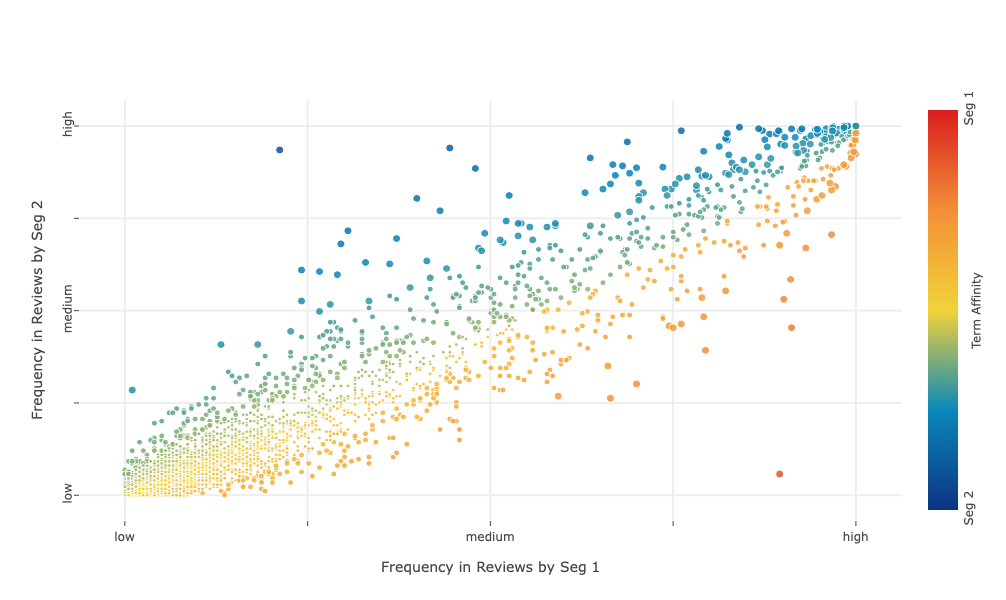

3863


In [8]:
layout= go.Layout(
    hovermode= 'closest',
    autosize=False,
    width=700,
    height=600,
    xaxis= dict(
        title='Frequency in Reviews by Seg 1',
        ticklen= 5,
        tickmode='array',
        tickvals=np.linspace(df['fseg1n'].min(), df['fseg1n'].max(), num=5),
        ticktext=['low', '', 'medium', '', 'high'],
        zeroline= False,
        gridwidth= 2,
        showticklabels=True,
        showgrid=True,
                ),
    yaxis=dict(
        ticklen= 5,
        tickmode='array',
        tickvals=np.linspace(df['fseg2n'].min(), df['fseg2n'].max(), num=5),
        ticktext=['low', '', 'medium', '', 'high'],
        gridwidth= 2,
        zeroline=False,
        showticklabels=True,
        showgrid=True,
        tickangle=-90,
        title='Frequency in Reviews by Seg 2',
                ))

# 'Greys', 'YlGnBu', 'Greens', 'YlOrRd', 'Bluered', 'RdBu', 'Reds', 'Blues', 'Picnic', 'Rainbow', 'Portland', 'Jet',
# 'Hot', 'Blackbody', 'Earth', 'Electric', 'Viridis', 'Cividis'

trace1 = go.Scatter(
    x = df['fseg1n'],
    y = df['fseg2n'],
    mode = 'markers',
    hoverinfo='text', 
    marker=dict(
                cmin=-1,
                cmax=1,
                size=df['fscore'].apply(scale_marker), 
                opacity=0.85,
                color=df['fscore'],
                colorbar = dict(
                                title = 'Term Affinity',
                                titleside = 'right',
                                tickmode = 'array',
                                tickvals = np.linspace(-1,1, num=9),
                                ticktext = ['Seg 2','','','','','','', '', 'Seg 1'],
                                ticks = '',
                                tickangle=-90,
                                outlinewidth=0
                                ),
                colorscale='Portland',
               ),
    text=df.index)


fig=go.Figure(data=[trace1], layout=layout)

iplot(fig)

print(len(df))

In [9]:
df.head()

,#seg1,#seg2,pseg1,pseg2,fseg1,fseg2,fscseg1,fscseg2,pseg1n,fseg1n,pseg2n,fseg2n,fscseg1n,fscseg2n,fscore
aami,56.0,27.0,0.674699,0.325301,0.000132,0.000075,0.000264,0.000150,0.602790,0.594843,0.397210,0.527529,0.598790,0.453187,0.197581
ability,22.0,17.0,0.564103,0.435897,0.000052,0.000047,0.000104,0.000094,0.486942,0.501926,0.513058,0.496401,0.494321,0.504592,-0.009184
able,250.0,325.0,0.434783,0.565217,0.000590,0.000900,0.001179,0.001798,0.353568,0.943177,0.646432,0.991711,0.514330,0.782683,-0.565366
aboriginal,180.0,123.0,0.594059,0.405941,0.000425,0.000341,0.000849,0.000681,0.518629,0.863852,0.481371,0.793508,0.648137,0.599229,0.296274
aborigine,9.0,20.0,0.310345,0.689655,0.000021,0.000055,0.000043,0.000111,0.240180,0.466091,0.759820,0.505746,0.317005,0.607279,-0.214558


In [47]:
df['#seg1'].quantile(q=[0.1, 0.5, 0.9])

0.1     4.0
0.5    12.0
0.9    98.0
Name: #seg1, dtype: float64

In [58]:
df['#seg2'].quantile(q=[0.1, 0.5, 0.9])

0.1      9.0
0.5     31.0
0.9    263.0
Name: #seg2, dtype: float64

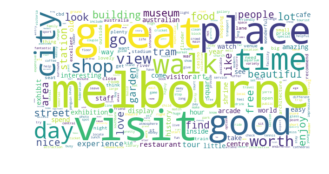

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud_seg1 = WordCloud(background_color='white', 
                           width=600, height=300, max_words=300).generate_from_frequencies(df[['#seg1']].to_dict()['#seg1'])


plt.figure(figsize=(5,3))
plt.imshow(wordcloud_seg1, interpolation='bilinear')
plt.axis("off")
plt.savefig('wc_segQ.png', dpi=300, bbox_inches = 'tight',
    pad_inches = 0)

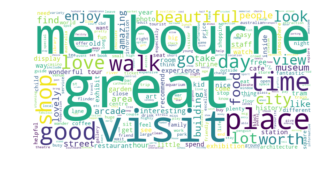

In [68]:
wordcloud_seg2 = WordCloud(background_color='white', width=800, height=400, max_words=300).generate_from_frequencies(df[['#seg2']].to_dict()['#seg2'])

plt.figure(figsize=(5,3))
plt.imshow(wordcloud_seg2, interpolation='bilinear')
plt.axis("off")
plt.savefig('wc_seg2.png', dpi=300)

In [69]:
df.head()

,#seg1,#seg2,pseg1,pseg2,fseg1,fseg2,fscseg1,fscseg2,pseg1n,fseg1n,pseg2n,fseg2n,fscseg1n,fscseg2n,fscore
aami,54.0,27.0,0.666667,0.333333,0.000128,0.000075,0.000257,0.000151,0.593606,0.590002,0.406394,0.527783,0.591799,0.459202,0.183598
ability,22.0,17.0,0.564103,0.435897,0.000052,0.000047,0.000105,0.000095,0.485942,0.502131,0.514058,0.496557,0.493904,0.505156,-0.010312
able,248.0,322.0,0.435088,0.564912,0.000590,0.000898,0.001178,0.001793,0.352904,0.942337,0.647096,0.991353,0.513502,0.783058,-0.566117
aboriginal,180.0,123.0,0.594059,0.405941,0.000428,0.000343,0.000855,0.000685,0.517636,0.864878,0.482364,0.794365,0.647649,0.600242,0.295299
aborigine,9.0,20.0,0.310345,0.689655,0.000021,0.000056,0.000043,0.000112,0.239347,0.466158,0.760653,0.505931,0.316294,0.607679,-0.215358
